In [1]:
import pandas as pd
import numpy as np

from sklearn.tree import export_text

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction import DictVectorizer

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import precision_score, recall_score, confusion_matrix, roc_auc_score, accuracy_score, f1_score, classification_report

In [2]:
# Load data splits
df_full_train = pd.read_parquet("../data/interim/df_full_train.parquet")
df_train = pd.read_parquet("../data/interim/df_train.parquet")
df_val = pd.read_parquet("../data/interim/df_val.parquet")
df_test = pd.read_parquet("../data/interim/df_test.parquet")

# Load target variables
y_train = np.load("../data/interim/y_train.npy")
y_val = np.load("../data/interim/y_val.npy")
y_test = np.load("../data/interim/y_test.npy")

In [5]:
numerical = [
    'time_in_hospital',
    'num_lab_procedures',
    'num_procedures',
    'num_medications',
    'number_outpatient',
    'number_emergency',
    'number_inpatient',
    'number_diagnoses',
    'total_previous_visits',
    'had_previous_inpatient',
    'avg_medications_per_day',
    'procedure_to_lab_ratio',
    'num_medications_used',
    'num_adjusted_medications',
    'any_medication_change',
    'on_insulin'
]

categorical = ['race', 'gender', 'age', 'diag_1', 'diag_2', 'diag_3', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed']

# One-hot encoding

In [6]:
dv = DictVectorizer(sparse=False)

In [7]:
train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

# Training Random Forest

In [8]:
from IPython.display import display

In [7]:
scores = []

for n in range(10, 201, 10):
    print(n)
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    scores.append((n, auc))

10
20


KeyboardInterrupt: 

In [ ]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])

In [ ]:
plt.plot(df_scores.n_estimators, df_scores.auc)

In [ ]:
n_estimators=150

In [ ]:
scores = []

for d in [5, 10, 15]:
    print(d)
    for n in range(10, 201, 10):
        print(n)
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    n_jobs=-1,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((d, n, auc))

In [ ]:
columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

In [ ]:
for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='max_depth=%d' % d)

plt.legend()

In [ ]:
df_scores.groupby('max_depth')['auc'].max()

In [ ]:
max_depth = 15

In [ ]:
scores = []

for s in [1, 3, 5, 10, 50]:
    print(s)
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    class_weight='balanced',
                                    max_features='sqrt',
                                    n_jobs=-1,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((s, n, auc))

In [ ]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

colors = ['black', 'blue', 'orange', 'red', 'grey']
values = [1, 3, 5, 10, 50]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             color=col,
             label='min_samples_leaf=%d' % s)

plt.legend()

In [ ]:
df_scores.groupby('min_samples_leaf')['auc'].max()

In [ ]:
min_samples_leaf = 3

In [9]:
rf = RandomForestClassifier(n_estimators=150,
                            max_depth=15,
                            min_samples_leaf=3,
                            class_weight='balanced',
                            max_features='sqrt',
                            n_jobs=-1,
                            random_state=1)
rf.fit(X_train, y_train)

,n_estimators,150
,criterion,'gini'
,max_depth,15
,min_samples_split,2
,min_samples_leaf,3
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [10]:
y_pred = rf.predict_proba(X_val)[:, 1]

## Evaluation of Random Forest

In [11]:
auc = roc_auc_score(y_val, y_pred)

precision = precision_score(y_val, y_pred >= 0.5)

recall = recall_score(y_val, y_pred >= 0.5)

f1 = f1_score(y_val, y_pred >= 0.5)

classification_report = classification_report(y_val, y_pred >= 0.5)

print(f"AUC: {auc:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")
# print(classification_report)


AUC: 0.633
Precision: 0.170
Recall: 0.505
F1 Score: 0.254


Random Forest model significantly improves the model’s ability to identify patients at risk of hospital readmission. 

Although its AUC score (0.633) is similar to Logistic Regression, its recall score (0.505) is substantially higher. This means the model successfully detects half of all patients who will be readmitted within 30 days, compared to only 1% with logistic regression.

However, this improvement comes with a decrease in precision (0.170), meaning the model produces more false positives. In a healthcare setting, this trade-off is acceptable because it is more important to catch at-risk patients early, even if some patients are flagged unnecessarily.

## Evaluate the model on different thresholds

In [12]:
thresholds = np.linspace(0, 1, 21)

rows = []

for t in thresholds:
    # Convert probabilities to 0/1 using threshold t
    y_pred_bin = (y_pred >= t)
    
    # If model predicts all zeros, precision is undefined → handle that
    if y_pred_bin.sum() == 0:
        p = 0.0
        r = 0.0
        f1 = 0.0
    else:
        p = precision_score(y_val, y_pred_bin)
        r = recall_score(y_val, y_pred_bin)
        f1 = f1_score(y_val, y_pred_bin)
    
    rows.append((t, p, r, f1))

df_thr_rf = pd.DataFrame(rows, columns=['threshold', 'precision', 'recall', 'f1'])
df_thr_rf.head()


,threshold,precision,recall,f1
0,0.00,0.112563,1.0,0.202349
1,0.05,0.112563,1.0,0.202349
2,0.10,0.112563,1.0,0.202349
3,0.15,0.112563,1.0,0.202349
4,0.20,0.112563,1.0,0.202349


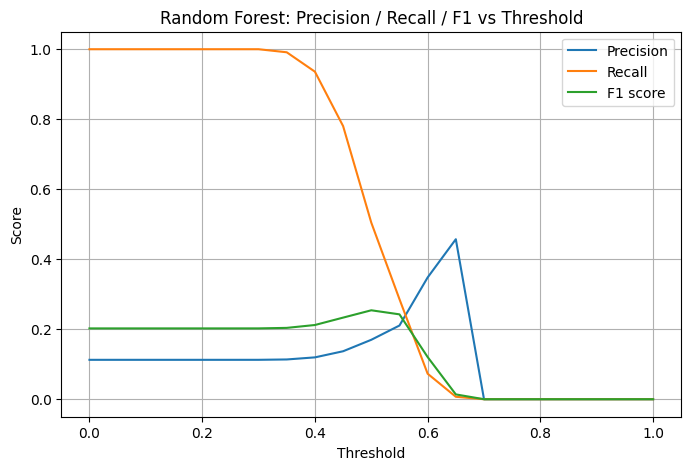

In [13]:
plt.figure(figsize=(8, 5))
plt.plot(df_thr_rf.threshold, df_thr_rf.precision, label='Precision')
plt.plot(df_thr_rf.threshold, df_thr_rf.recall, label='Recall')
plt.plot(df_thr_rf.threshold, df_thr_rf.f1, label='F1 score')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Random Forest: Precision / Recall / F1 vs Threshold')
plt.grid(True)
plt.legend()
plt.show()

In [14]:
best_row = df_thr_rf.loc[df_thr_rf.f1.idxmax()]
best_row

threshold    0.500000
precision    0.169800
recall       0.504583
f1           0.254094
Name: 10, dtype: float64

In [15]:
best_threshold = best_row.threshold
print("Best F1 threshold:", best_threshold)
print("Precision:", best_row.precision)
print("Recall:", best_row.recall)
print("F1:", best_row.f1)

Best F1 threshold: 0.5
Precision: 0.1698002350176263
Recall: 0.5045831514622435
F1: 0.2540938564677437


# Training XGBoost

In [4]:
!pip install xgboost


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip


In [5]:
import xgboost as xgb

In [ ]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [1]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=10)

NameError: name 'xgb' is not defined

In [ ]:
y_pred = model.predict(dval)

In [ ]:
roc_auc_score(y_val, y_pred)

In [ ]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [ ]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [ ]:
s = output.stdout

In [ ]:
print(s[:200])

In [ ]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [ ]:
df_score = parse_xgb_output(output)

In [ ]:
plt.plot(df_score.num_iter, df_score.train_auc, label='train')
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

In [ ]:
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

# XGBoost parameter tuning

In [ ]:
scores = {}

In [ ]:
%%capture output

xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [ ]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

In [ ]:
score = {}

In [ ]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 10,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [ ]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

In [ ]:
del scores['max_depth=10']

In [ ]:
df_score

In [ ]:
scores
for max_depth, df_score in scores.items():
    print(df_score)
    plt.plot(df_score.num_iter, df_score.val_auc, label=max_depth)

# plt.ylim(0.5, 0.6)
plt.legend()

In [ ]:
scores = {}

In [ ]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 30,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [ ]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)
key

In [ ]:
for min_child_weight, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=min_child_weight)

# plt.ylim(0.82, 0.84)
plt.legend()

In [ ]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100)

In [ ]:
auc = roc_auc_score(y_val, y_pred)
print(f"AUC: {auc:.3f}")

# Thresold

In [ ]:
thresholds = np.linspace(0, 1, 101)
rows = []
for t in thresholds:
    y_hat = (y_pred >= t)
    rows.append({
        "threshold": t,
        "precision": precision_score(y_val, y_hat, zero_division=0),
        "recall":    recall_score(y_val, y_hat, zero_division=0),
        "f1":        f1_score(y_val, y_hat, zero_division=0),
    })

df_scores = pd.DataFrame(rows)
best = df_scores.loc[df_scores['f1'].idxmax()]
print(best)